# Deep learning model for the blood dataset

In [1]:
from __future__ import print_function

#Basic libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

import random
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image


data_path = './data/blood_cells_classification'

/home/ubuntu/anaconda3/envs/tf18/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version:  1.8.0


In [2]:
# List categories in train data
categories = sorted(os.listdir(os.path.join(data_path, 'train')))
categories


['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

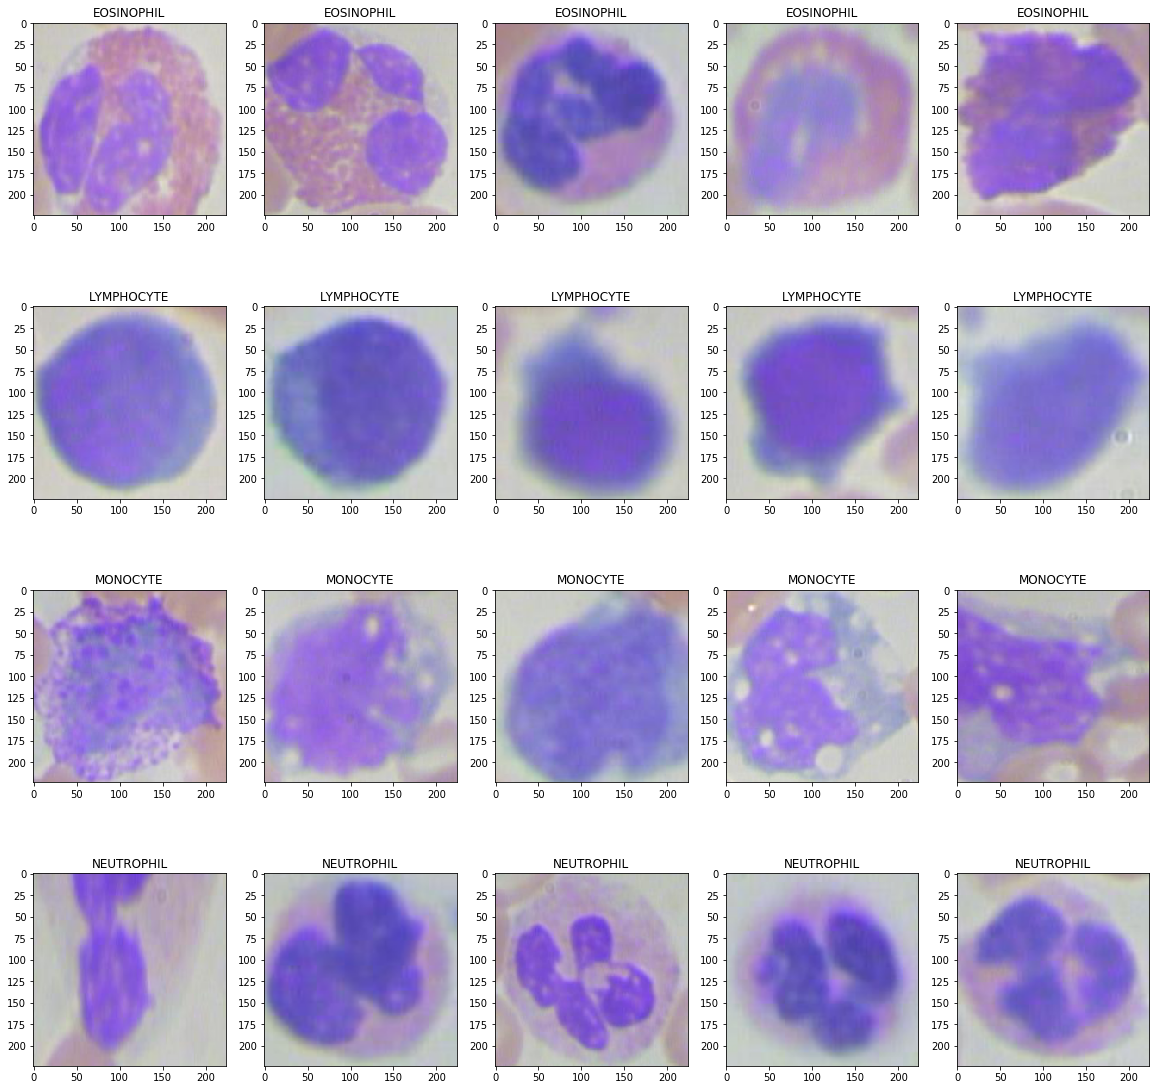

In [3]:
# Examine the data
plt.rcParams['figure.figsize'] = (20, 20) 

fig = plt.figure()
n=0
for i, category in enumerate(categories):
    filelist = [f for f in os.listdir(os.path.join(data_path, 'train', category)) if os.path.isfile(os.path.join(data_path, 'train', category, f))]
    random.shuffle(filelist) # Randomize images
    for f in filelist[:5]: 
        n += 1
        a = fig.add_subplot(4, 5, n)
        a.set_title(category)
        img = plt.imread(os.path.join(data_path, 'train', category, f))
        plt.imshow(img)
    

    

In [4]:
def load_data(data_path):
    X = []
    y = []
    for c in os.listdir(data_path):
        print(c, ' num cases: ', len(os.listdir(os.path.join(data_path,c))))
        for f in os.listdir(os.path.join(data_path, c)):
            im = Image.open(os.path.join(data_path, c, f))
            im = im.resize((64,64))
            img = np.array(im)
            X += [img[:,:,:3]]
            y += [c]
    return np.array(X), np.array(y)

In [5]:
X_trn, y_trn_txt = load_data(os.path.join(data_path, 'train'))
print(X_trn.shape)
print(y_trn_txt.shape)

LYMPHOCYTE  num cases:  35
EOSINOPHIL  num cases:  64
MONOCYTE  num cases:  17
NEUTROPHIL  num cases:  198
(314, 64, 64, 3)
(314,)


In [6]:
X_tst, y_tst_txt = load_data(os.path.join(data_path, 'test'))
print(X_tst.shape)
print(y_tst_txt.shape)

LYMPHOCYTE  num cases:  6
EOSINOPHIL  num cases:  10
MONOCYTE  num cases:  3
NEUTROPHIL  num cases:  13
(32, 64, 64, 3)
(32,)


In [7]:
# Encode target
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_trn = le.fit_transform(y_trn_txt)
y_tst = le.transform(y_tst_txt) 

print(list(le.inverse_transform([0, 1, 2, 3])))

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


/home/ubuntu/anaconda3/envs/tf18/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
# First model

#from tensorflow.contrib.keras import models, layers, optimizers, callbacks, preprocessing

#Inputs
images = tf.keras.layers.Input(batch_shape=(None, 64, 64, 3), dtype='float32', name='Images')

#First convolutional layer
conv11 = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu')(images)
conv12 = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu')(conv11)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv12)

#Second convolutional layer
conv21 = tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu')(pool1)
conv22 = tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu')(conv21)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv22)
#pool2d = tf.keras.layers.Dropout(0.5)(pool2)

#Dense layers
flat = tf.keras.layers.GlobalAveragePooling2D()(pool2)
dense1 = tf.keras.layers.Dense(256, activation='relu', name='Dense_1')(flat)
dense1d = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(4, activation='softmax', name='Dense_output')(dense1d)


# Model Architecture defined
model1 = tf.keras.models.Model(inputs=images, outputs=output)
model1.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
__________

In [9]:
# Select optimizer and compile model
opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-4)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [10]:
tb_callback_ln = tf.keras.callbacks.TensorBoard(log_dir='./tensorboard/blood/scratch/')

history1 = model1.fit(X_trn, y_trn, batch_size=16, epochs=50,
                            verbose=1, validation_data=(X_tst, y_tst), callbacks=[tb_callback_ln])
                                  


Train on 314 samples, validate on 32 samples
Epoch 1/50
314/314 [==============================] - 3s 10ms/step - loss: 5.9406 - acc: 0.5987 - val_loss: 5.1089 - val_acc: 0.4062
Epoch 2/50
314/314 [==============================] - 0s 926us/step - loss: 1.5757 - acc: 0.5191 - val_loss: 1.2659 - val_acc: 0.4062
Epoch 3/50
314/314 [==============================] - 0s 858us/step - loss: 1.1111 - acc: 0.6146 - val_loss: 1.2671 - val_acc: 0.4062
Epoch 4/50
314/314 [==============================] - 0s 819us/step - loss: 1.0825 - acc: 0.6083 - val_loss: 1.2746 - val_acc: 0.4062
Epoch 5/50
314/314 [==============================] - 0s 805us/step - loss: 1.1142 - acc: 0.6306 - val_loss: 1.7503 - val_acc: 0.4062
Epoch 6/50
314/314 [==============================] - 0s 817us/step - loss: 1.0251 - acc: 0.5987 - val_loss: 1.2314 - val_acc: 0.4062
Epoch 7/50
314/314 [==============================] - 0s 811us/step - loss: 1.0331 - acc: 0.6083 - val_loss: 1.5941 - val_acc: 0.4062
Epoch 8/50
314/314

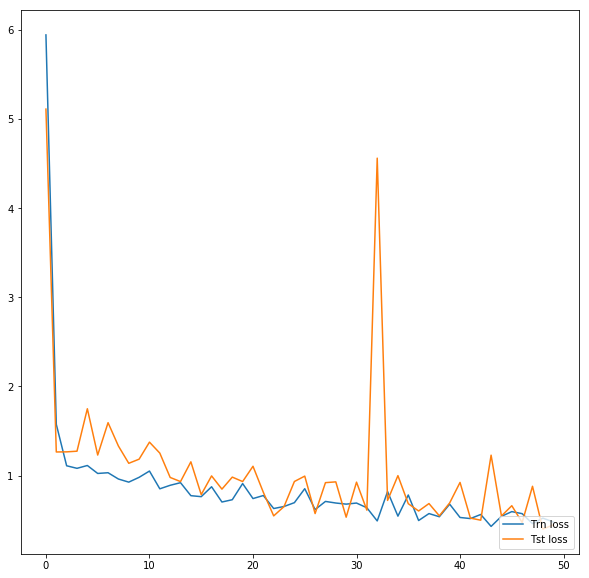

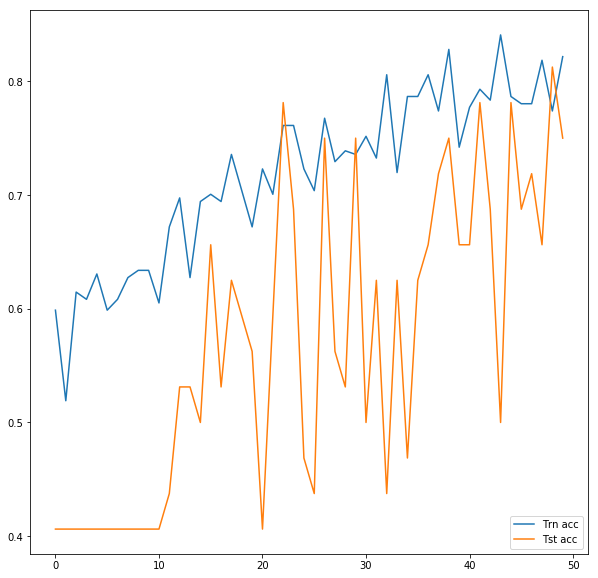

In [11]:
# Plot history
plt.rcParams['figure.figsize'] = (10, 10)        # size of images

plt.plot(history1.history['loss'], label='Trn loss')
plt.plot(history1.history['val_loss'], label='Tst loss')
plt.legend(loc='lower right')
plt.show()

plt.plot(history1.history['acc'], label='Trn acc')
plt.plot(history1.history['val_acc'], label='Tst acc')
plt.legend(loc='lower right')
plt.show()

In [12]:
# Score and select prediction with max prob
p_test = model1.predict(X_tst)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(categories)
print(confusion_matrix(y_tst_txt, [categories[i] for i in pred_test]))

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
[[9 0 0 1]
 [0 6 0 0]
 [0 3 0 0]
 [4 0 0 9]]


## Alternative architecture with one conv-maxpool set of layers and a dense layer of half size

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

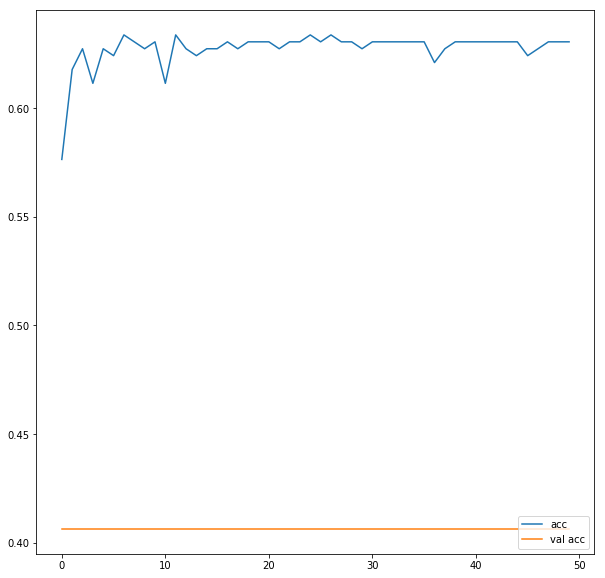

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
[[ 0  0  0 10]
 [ 0  0  0  6]
 [ 0  0  0  3]
 [ 0  0  0 13]]


In [13]:
images = tf.keras.layers.Input(batch_shape=(None, 64, 64, 3), dtype='float32', name='Images')

#First convolutional layer
conv11 = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu')(images)
conv12 = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu')(conv11)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv12)

#Dense layers
flat = tf.keras.layers.GlobalAveragePooling2D()(pool1)
dense1 = tf.keras.layers.Dense(128, activation='relu', name='Dense_1')(flat)
dense1d = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(4, activation='softmax', name='Dense_output')(dense1d)


# Model Architecture defined
model2 = tf.keras.models.Model(inputs=images, outputs=output)
model2.summary()

opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-3)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history2 = model2.fit(X_trn, y_trn, batch_size=16, epochs=50,
                            verbose=1, validation_data=(X_tst, y_tst))

plt.plot(history2.history['acc'], label='acc')
plt.plot(history2.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

# Score and select prediction with max prob
p_test = model2.predict(X_tst)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(categories)
print(confusion_matrix(y_tst_txt, [categories[i] for i in pred_test]))